#Twitter  Analysis 

a. Import required libraries (recommended- use tensorflow/keras library).

b. Import the dataset (use Google Drive if required).

c. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [167]:
import nltk
from nltk.corpus import stopwords
import re
import joblib
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import tensorflow as tf
from keras.datasets import cifar10
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


In [169]:
import pandas as pd 

# Reading the data from google drives
twitterData = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='latin-1',header=None)

columns=['target','ids','date','flag','user','tweet']
twitterData.columns=columns

twitterData.head()
twitterData['tweet'] = twitterData['tweet'].astype(str) 
twitterData.dtypes


target     int64
ids        int64
date      object
flag      object
user      object
tweet     object
dtype: object

In [170]:
def preprocessing_text(twitterData):
    #put everythin in lowercase
    twitterData['tweet'] = twitterData['tweet'].str.lower()
    #Replace rt indicating that was a retweet
    twitterData['tweet'] = twitterData['tweet'].str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    twitterData['tweet'] = twitterData['tweet'].replace(r'@\w+', '', regex=True)
    #Replace links contained in the tweet
    twitterData['tweet'] = twitterData['tweet'].replace(r'http\S+', '', regex=True)
    twitterData['tweet'] = twitterData['tweet'].replace(r'www.[^ ]+', '', regex=True)
    #remove numbers
    twitterData['tweet'] = twitterData['tweet'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    twitterData['tweet'] = twitterData['tweet'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    return twitterData



a. Print at least two tweets from each class of the dataset, for a sanity check that labels match the text.

b. Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a
particular sentiment. (recommended - matplotlib/seaborn libraries)

c. Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for
the points.

d. Print the shapes of train and test data

In [171]:
twitterData  = preprocessing_text(twitterData)

twitterData.target.replace({0:'Negative',2:'Neutral',4:'Positive'},inplace=True)

twitterData.head()

,target,ids,date,flag,user,tweet
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww that's a bummer you shoulda got david...
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sa...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no it's not behaving at all i'm mad why am i ...


In [172]:
stop_words=set(stopwords.words('english'))
import re
corpus=[]
for i in range(0,len(twitterData)):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',twitterData['tweet'][i])
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    review=' '.join(review)
    corpus.append(review)

twitterData.tweet=corpus
twitterData.head()

,target,ids,date,flag,user,tweet
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save rest go bounds
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


In [173]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(twitterData,test_size=0.20,random_state=123)

In [174]:
train_df.head()


,target,ids,date,flag,user,tweet
27146,Negative,1559066190,Sun Apr 19 10:10:00 PDT 2009,NO_QUERY,paulrichardson,pay last night good old emma comes trumps food...
29909,Negative,1563619868,Sun Apr 19 23:32:55 PDT 2009,NO_QUERY,dustinwill,yess wtff well least one thanks
981,Negative,1468052470,Mon Apr 06 23:27:48 PDT 2009,NO_QUERY,Meg_Nutz,seating helping baby paperswell forcing seat i...
34990,Negative,1565034564,Mon Apr 20 05:42:31 PDT 2009,NO_QUERY,abjohnson85,enjoying marathon monday confines cubicle sure...
15886,Negative,1555691706,Sat Apr 18 20:25:28 PDT 2009,NO_QUERY,oldbluebox,cody making play ld christopher room


In [175]:
test_df.head()

,target,ids,date,flag,user,tweet
25532,Negative,1558371151,Sun Apr 19 08:09:59 PDT 2009,NO_QUERY,mhk794,cold rainy
21401,Negative,1557272230,Sun Apr 19 03:03:53 PDT 2009,NO_QUERY,natcauliflower,oh get meet maybe find udo gardening careful l...
39607,Negative,1573572084,Tue Apr 21 01:48:42 PDT 2009,NO_QUERY,oz86,tricked seeing lol
27085,Negative,1559035759,Sun Apr 19 10:04:59 PDT 2009,NO_QUERY,a_paige,omg yes remember telling came smh glad pay haha
26744,Negative,1558880941,Sun Apr 19 09:39:39 PDT 2009,NO_QUERY,Heidi_vb,actually idea jst curious ur profile minimum l...


Neural Network Model

In [176]:
documents = [text.split() for text in x_train.tweet]
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [177]:
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2773


In [178]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(5056825, 7095090)

In [179]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.tweet)
vocab_size=len(tokenizer.word_index)+1
vocab_size

29183

In [180]:
X_train = pad_sequences(tokenizer.texts_to_sequences(x_train.tweet), maxlen=300)
X_train

array([[    0,     0,     0, ...,    15,    22,    42],
       [    0,     0,     0, ...,     2,   215, 10895],
       [    0,     0,     0, ...,   107,    57,    22],
       ...,
       [    0,     0,     0, ...,   116,  6348,    17],
       [    0,     0,     0, ...,   242,  7310, 29182],
       [    0,     0,     0, ...,    16,   520,    14]], dtype=int32)

In [181]:
X_test = pad_sequences(tokenizer.texts_to_sequences(x_test.tweet), maxlen=300)
X_test

array([[   0,    0,    0, ...,    6,  348,  348],
       [   0,    0,    0, ..., 1347,  634,  167],
       [   0,    0,    0, ...,   64,    2,   22],
       ...,
       [   0,    0,    0, ...,   84,  341,  587],
       [   0,    0,    0, ...,  178,  171, 3839],
       [   0,    0,    0, ...,  141,  320,   14]], dtype=int32)

In [182]:
y_train=X_train.target
y_test=X_test.target
y_train.head()

42292    Negative
11126    Negative
19555    Negative
41672    Negative
26671    Negative
Name: target, dtype: object

In [183]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test=labelencoder.fit_transform(y_test)
y_train.shape
y_test.shape

print('Training datadetails X=%s,Y=%s'%(X_train.shape,y_train.shape))
print('Test datadetails x=%s,y=%s'%(X_test.shape,y_test.shape))

(8475,)

In [184]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(29183, 300)


In [185]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [186]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          8754900   
_________________________________________________________________
dropout_13 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 8,915,401
Trainable params: 160,501
Non-trainable params: 8,754,900
_________________________________________________________________


5. Model Compilation (0.25 mark)

      a. Compile the model with the appropriate loss function.

      b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

      c. Use accuracy as metric.

In [187]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

6. Model Training (0.5 + 0.5 = 1 mark)

    a. Train the model for an appropriate number of epochs (print the train and validation accuracy/loss for
each epoch). Use the appropriate batch size.

    b. Plot the loss and accuracy history graphs. Print the total time taken for training.

In [188]:
model_history=model.fit(X_train, y_train,batch_size=1024,epochs=5,validation_split=0.1,verbose=1)

Epoch 1/5
30/30 [==============================] - 377s 13s/step - loss: 0.1642 - accuracy: 0.9666 - val_loss: 4.0727e-05 - val_accuracy: 1.0000
Epoch 2/5
30/30 [==============================] - 376s 13s/step - loss: 2.9655e-05 - accuracy: 1.0000 - val_loss: 1.7564e-05 - val_accuracy: 1.0000
Epoch 3/5
30/30 [==============================] - 379s 13s/step - loss: 2.0183e-05 - accuracy: 1.0000 - val_loss: 1.5249e-05 - val_accuracy: 1.0000
Epoch 4/5
30/30 [==============================] - 374s 12s/step - loss: 1.7947e-05 - accuracy: 1.0000 - val_loss: 1.3718e-05 - val_accuracy: 1.0000
Epoch 5/5
30/30 [==============================] - 374s 12s/step - loss: 1.6208e-05 - accuracy: 1.0000 - val_loss: 1.2338e-05 - val_accuracy: 1.0000


7. Model Evaluation (0.25 + 0.75 = 1 mark)

    a. Print the final test/validation loss and accuracy.

    b. Print confusion matrix and classification report for the validation dataset. Write a summary for the
best and worst performing class and the overall trend.

In [189]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

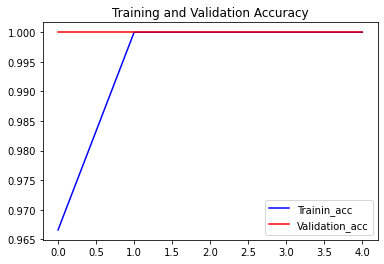

In [190]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

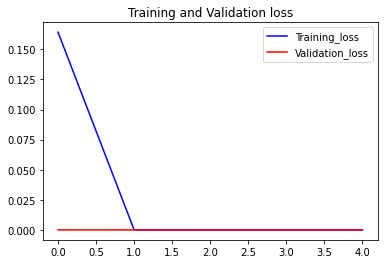

In [191]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [ ]:
def preprocess(tweet):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',tweet)
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    print(review)
    review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)
    return review

In [192]:
def prediction(review):
    review=preprocess(review)
    score=model.predict(review)
    score=score[0]
    if score<0.4:
        print("Negative")
    elif score>0.4 and score<0.6:
        print("Neutral")
    else:
        print("Positive")
    print(score)

In [193]:
scores = model.predict(X_test, verbose=1, batch_size=1024)

9/9 [==============================] - 19s 2s/step


In [194]:
scores

array([[9.0293834e-06],
       [1.3834462e-05],
       [8.0891186e-06],
       ...,
       [1.4659309e-05],
       [1.3522329e-05],
       [7.7875720e-06]], dtype=float32)

In [202]:
y_pred=np.where(scores>0.5,1,0)

In [203]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [197]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [206]:
cm=confusion_matrix(y_pred,y_test)
print(cm)

[[8475]]


In [199]:
print(accuracy_score(y_pred,y_test))

1.0


In [200]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8475

    accuracy                           1.00      8475
   macro avg       1.00      1.00      1.00      8475
weighted avg       1.00      1.00      1.00      8475



Hyperparameter Tuning- Build two more models by changing the following hyperparameters one at a time (0.5 + 0.5
= 1 mark)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          8754900   
_________________________________________________________________
dropout_14 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 8,915,401
Trainable params: 160,501
Non-trainable params: 8,754,900
_________________________________________________________________
Epoch 1/2
30/30 [==============================] - 370s 12s/step - loss: 0.0063 - accuracy: 0.9993 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
9/9 [==============================] - 19s 2s/step
[[8475]]
1.0
              pre

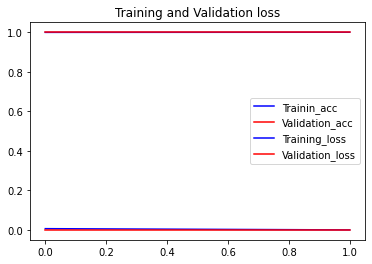

In [207]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])


model_history=model.fit(X_train, y_train,batch_size=1024,epochs=2,validation_split=0.1,verbose=1)


acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))


plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")


plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")


scores = model.predict(X_test, verbose=1, batch_size=1024)

y_pred=np.where(scores>0.5,1,0)


cm=confusion_matrix(y_pred,y_test)
print(cm)

print(accuracy_score(y_pred,y_test))

print(classification_report(y_test, y_pred))

tanh

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          8754900   
_________________________________________________________________
dropout_15 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 8,915,401
Trainable params: 160,501
Non-trainable params: 8,754,900
_________________________________________________________________
Epoch 1/2
30/30 [==============================] - 380s 13s/step - loss: 0.0070 - accuracy: 0.9994 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
9/9 [==============================] - 20s 2s/step
[[8475]]
1.0
              pre

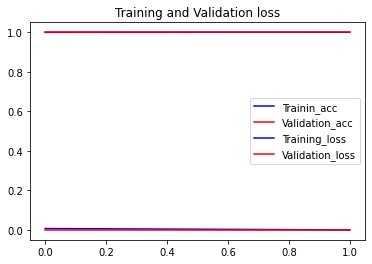

In [208]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='tanh'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])


model_history=model.fit(X_train, y_train,batch_size=1024,epochs=2,validation_split=0.1,verbose=1)


acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))





scores = model.predict(X_test, verbose=1, batch_size=1024)

y_pred=np.where(scores>0.5,1,0)


cm=confusion_matrix(y_pred,y_test)
print(cm)

print(accuracy_score(y_pred,y_test))

print(classification_report(y_test, y_pred))

Text(0.5, 1.0, 'Training and Validation Accuracy')

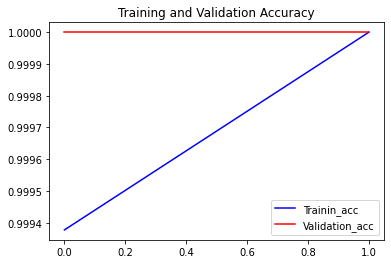

In [209]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")



Text(0.5, 1.0, 'Training and Validation loss')

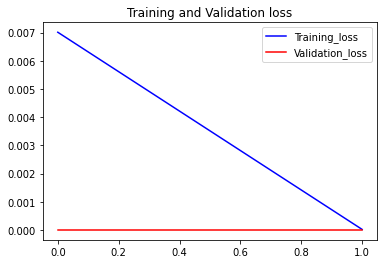

In [210]:

plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")